Distribución de clases (0 = no fraude, 1 = fraude):
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

Porcentaje de cada clase:
is_fraud
0    99.48
1     0.52
Name: proportion, dtype: float64


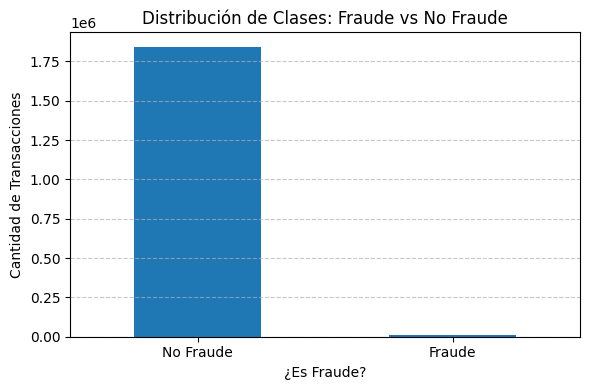

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('data.csv')  # Cambia por el nombre de tu archivo real

df['is_fraud'] = df['is_fraud'].astype(int)

# Conteo de clases
class_counts = df['is_fraud'].value_counts()
print("Distribución de clases (0 = no fraude, 1 = fraude):")
print(class_counts)

# Porcentaje
class_percent = df['is_fraud'].value_counts(normalize=True) * 100
print("\nPorcentaje de cada clase:")
print(class_percent.round(2))

# Visualización
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title("Distribución de Clases: Fraude vs No Fraude")
plt.xlabel("¿Es Fraude?")
plt.ylabel("Cantidad de Transacciones")
plt.xticks(ticks=[0,1], labels=["No Fraude", "Fraude"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
# Transacciones por usuario
df['transacciones_por_usuario'] = df.groupby('cc_num')['cc_num'].transform('count')

# Monto total gastado por usuario
df['monto_total_usuario'] = df.groupby('cc_num')['amt'].transform('sum')

# Promedio de gasto por usuario
df['monto_promedio_usuario'] = df['monto_total_usuario'] / df['transacciones_por_usuario']

# quincena
df['quincena'] = df['trans_day'].apply(lambda d: 'quincena_1' if d <= 15 else 'quincena_2')


#compras lejanas
df["is_international_guess"] = df["dist_between_client_and_merch"] > 1000


# Compra de noche #horas de la noche
df['es_noche'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Distancia sospechosa
df['distancia_muy_lejana'] = (df['dist_between_client_and_merch'] > 100).astype(int)


In [4]:
categorias_riesgosas = ['misc_net', 'shopping_net', 'shopping_pos']

df['comercio_riesgoso'] = df['category'].isin(categorias_riesgosas).astype(int)


riesgo_por_categoria = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
print(riesgo_por_categoria)


category
shopping_net      0.015927
misc_net          0.013039
grocery_pos       0.012645
shopping_pos      0.006344
gas_transport     0.004106
misc_pos          0.002819
grocery_net       0.002697
travel            0.002692
personal_care     0.002229
entertainment     0.002177
kids_pets         0.001880
food_dining       0.001568
home              0.001510
health_fitness    0.001510
Name: is_fraud, dtype: float64


In [5]:
umbral_alto = df['amt'].quantile(0.90)  # o cualquier otro criterio

df['transaccion_alto_riesgo'] = ((df['amt'] > umbral_alto) & (df['comercio_riesgoso'] == 1)).astype(int)


In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Excluir columnas no útiles
exclude_cols = ['cc_num', 'first', 'last', 'street', 'job', 'dob', 'trans_num', 'merchant']
X = df.drop(columns=exclude_cols, errors='ignore')
y = df['is_fraud']

# 2. Convertir categóricas a dummies
X = pd.get_dummies(X)

# 3. Convertir booleanos a enteros
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# 4. Separar train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)



In [16]:
# 5. Modelo
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# 6. Predicciones y métricas
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5674
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 938
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251904
[LightGBM] [Info] Start training from score -5.251904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [17]:
print("✅ AUC-ROC:", round(auc, 4))
print("✅ F1 Score:", round(f1, 4))
print("\n📊 Matriz de Confusión:")
print(cm)


✅ AUC-ROC: 1.0
✅ F1 Score: 1.0

📊 Matriz de Confusión:
[[552824      0]
 [     0   2895]]


In [18]:
print("\n📋 Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))



📋 Reporte de clasificación:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552824
           1       1.00      1.00      1.00      2895

    accuracy                           1.00    555719
   macro avg       1.00      1.00      1.00    555719
weighted avg       1.00      1.00      1.00    555719



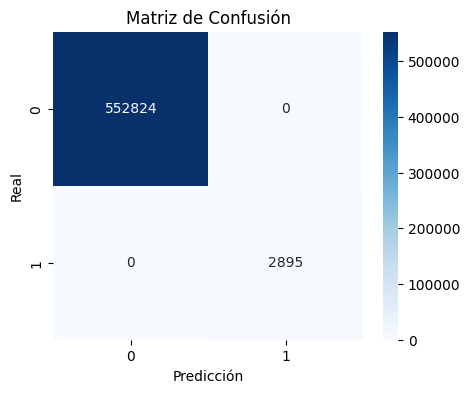

In [19]:
# 7. Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [23]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. Métrica personalizada: ratio de falsos positivos ===
def false_positive_ratio_score(preds, train_data):
    y_true = train_data.get_label()
    y_pred = (preds >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape != (2, 2):
        return 'false_positive_ratio', float('inf'), False

    TN, FP, FN, TP = cm.ravel()
    score = (TP + FP) / TP if TP != 0 else float('inf')
    return 'false_positive_ratio', score, False  # menor es mejor

# === 2. Features dummies y split ===
exclude_cols = ['cc_num', 'first', 'last', 'street', 'job', 'dob', 'trans_num', 'merchant']
X = df.drop(columns=exclude_cols, errors='ignore')
y = df['is_fraud']

X = pd.get_dummies(X)
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [25]:
# === 3. Dataset para LightGBM ===
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# === 4. Parámetros con tuning básico ===
params = {
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 42,
    'max_depth': 7,
    'num_leaves': 64,
    'min_data_in_leaf': 10
}

# === 5. Entrenamiento con métrica personalizada ===
model_custom = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[valid_dataset],
    valid_names=['validación'],
    feval=false_positive_ratio_score,
    num_boost_round=100
)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5766
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 984
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251904
[LightGBM] [Info] Start training from score -5.251904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

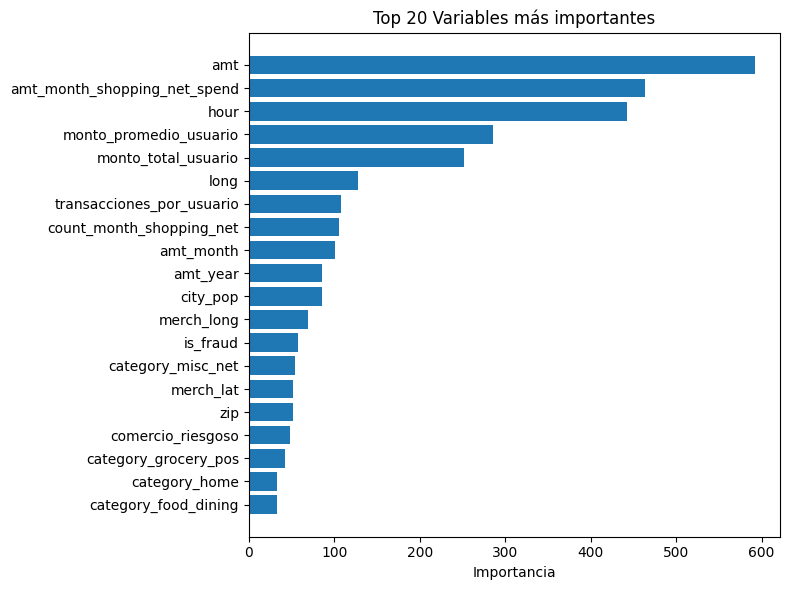

In [27]:
# === 6. Importancia de variables ===
importances = model_custom.feature_importance()
features = train_dataset.feature_name  # ❌ no uses paréntesis aquí
feat_imp = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

# === 7. Visualizar top 20 features ===
plt.figure(figsize=(8, 6))
plt.barh(feat_imp.head(20)['feature'][::-1], feat_imp.head(20)['importance'][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 Variables más importantes")
plt.tight_layout()
plt.show()
